In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import pymc as pm2
import numpy as np

from theano import tensor as T

Percent of ones: 0.145599365234


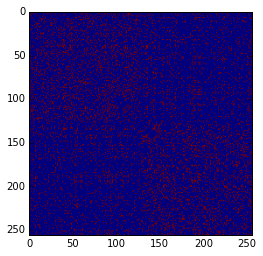

In [74]:
# Load in conv5 activation data and convert to binary convariance by a threshold
x = np.load('/home/ubuntu/sdf/activations/binary_10_conv5.npy')
plt.show()

width = x.shape[1]
cov = np.dot(x.transpose(), x)
for i in range(0, cov.shape[0]):
    cov[i, i] = 0
cov /= np.max(cov)

# Iterate to normalize the rows and columns
cov = np.divide(cov, np.tile(np.sum(cov, 0), (width, 1)))
cov = np.divide(cov, np.tile(np.sum(cov, 1), (width, 1)).transpose())
cov = np.divide(cov, np.tile(np.sum(cov, 0), (width, 1)))
cov = np.divide(cov, np.tile(np.sum(cov, 1), (width, 1)).transpose())

# Find the largest elements and convert to binary
observation_matrix = np.zeros(cov.shape, np.int32)
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        if cov[i, j] > 1.5 / width:
            observation_matrix[i, j] = 1
print("Percent of ones: " + str(float(np.sum(observation_matrix)) / width / width))
plt.imshow(observation_matrix)
plt.show()

num_data = observation_matrix.shape[0]

In [ ]:
# Generate random matrix
import random
num_data = 200
num_classes = 4

# Generate some classes
candidate = [i for i in range(0, num_data)]
classes = np.ndarray(num_data, np.int)
class_count = np.zeros(num_classes, np.int)
class_dist = pm2.Geometric('class_dist', 0.4)
for i in range(0, num_data):
    classes[i] = class_dist.random() - 1
    if classes[i] >= num_classes:
        classes[i] = random.randint(0, num_classes-1)
    class_count[classes[i]] += 1
prob_between_class = np.exp(-np.random.rand(num_classes, num_classes)*2)
print("Class size distribution: " + str(class_count))

In [ ]:
observation_matrix = np.zeros((num_data, num_data), np.int)
for i in range(0, num_data):
    for j in range(i, num_data):   
        if random.random() < prob_between_class[classes[i], classes[j]]:
            observation_matrix[i, j] = 1
        else:
            observation_matrix[i, j] = 0    
        observation_matrix[j, i] = observation_matrix[i, j]
plt.imshow(observation_matrix)
plt.show()

In [ ]:
# Plot correct results for randomly generated data
correct_order = np.argsort(classes)
# Permute the matrix according to the assignments
permuted = np.ndarray((num_data, num_data), np.int)
result = np.ndarray((num_data, num_data), np.int)
for i in range(0, num_data):
    permuted[i, :] = observation_matrix[correct_order[i], :]
for i in range(0, num_data):
    result[:, i] = permuted[:, correct_order[i]]
plt.imshow(result)
class_sum = 0
for i in range(0, num_classes-1):
    class_sum += class_count[i]
    plt.axhline(y=class_sum, c='g')
    plt.axvline(x=class_sum, c='g')
plt.show()

In [14]:
def flatten(mat):
    result = np.ndarray((num_data*num_data,), np.int)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            result[i * mat.shape[1] + j] = mat[i, j]
    return result

In [75]:
beta = 2
num_clusters = 4
 
alpha = pm2.Gamma('alpha', 1., 1.)
mu = pm2.Beta('mu', 2.0, 2.0, size=num_clusters*num_clusters)
# cluster_prior = pm.Dirichlet('cluster_prior', np.ones(num_clusters) / num_clusters)
beta = pm2.Beta('beta', 1., alpha, size=num_clusters)
@pm2.deterministic
def cluster_prior(beta=beta):
    unnormalized = beta * np.concatenate([[1], np.cumprod(1 - beta)[:-1]])
    return unnormalized / np.sum(unnormalized)

#print(beta.random())
# Normalize
assignment = pm2.Categorical('assignment', cluster_prior, size=num_data)

@pm2.deterministic
def prob(assignment1=assignment, assignment2=assignment, mu=mu):
    return [mu[a1 * num_clusters + a2] for a1 in assignment1 for a2 in assignment2]

observation = pm2.Bernoulli('observation', prob, observed=True, value=flatten(observation_matrix))

In [76]:
model = pm2.Model([alpha, mu, beta, cluster_prior, assignment, prob, observation])
mcmc_iter = 4000
mc = pm2.MCMC(model)
mc.sample(mcmc_iter, burn=2000)

 [-----------------100%-----------------] 4000 of 4000 complete in 162.6 sec

In [77]:
cluster_samples = mc.trace("cluster_prior")[:]
assignment_samples = mc.trace('assignment')[:]
import scipy
mode = scipy.stats.mode(assignment_samples, 0)[0][0]
cluster_posterior = list(np.sum(cluster_samples, 0) / float(mcmc_iter))
cluster_posterior /= np.sum(cluster_posterior)
order = np.argsort(mode)
count = np.zeros(num_clusters, np.int)
for item in mode:
    count[int(round(item))] += 1
print(cluster_posterior)
print(count)
print(mode)

[ 0.11764505  0.38506536  0.37017618  0.12711341]
[ 29 101  96  30]
[1 1 0 2 3 1 1 0 1 2 1 1 1 2 1 0 2 1 0 2 2 1 1 2 1 3 1 3 2 2 2 0 1 2 2 2 3
 2 1 2 1 2 2 2 2 2 1 2 1 2 3 2 0 0 0 1 1 3 0 1 3 3 1 3 1 3 1 3 1 2 2 1 1 1
 1 1 1 1 2 2 0 2 2 1 1 2 0 2 3 0 3 3 2 0 2 2 1 1 2 0 2 1 2 1 3 3 0 0 1 2 2
 2 1 0 3 1 2 2 1 2 1 2 3 1 3 2 3 2 2 1 2 1 1 1 2 1 2 2 2 3 2 1 1 1 1 2 2 0
 1 0 2 1 3 1 0 2 2 2 0 1 2 1 1 1 3 2 2 1 2 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 3
 2 3 2 2 2 2 1 1 2 0 0 1 1 0 2 2 2 0 2 1 2 0 1 3 2 1 2 2 3 2 1 1 1 3 1 1 0
 1 3 1 2 0 3 1 1 2 1 1 1 2 2 2 1 2 2 2 2 1 2 2 1 1 2 1 1 2 2 2 1 1 0]


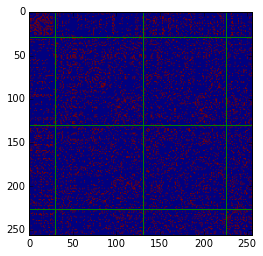

In [78]:
# Permute the matrix according to the assignments
permuted = np.ndarray((num_data, num_data), np.int)
result = np.ndarray((num_data, num_data), np.int)
for i in range(0, num_data):
    permuted[i, :] = observation_matrix[order[i], :]
for i in range(0, num_data):
    result[:, i] = permuted[:, order[i]]
class_sum = 0
for i in range(0, num_clusters-1):
    class_sum += count[i]
    plt.axhline(y=class_sum, c='g')
    plt.axvline(x=class_sum, c='g')
plt.imshow(result)
plt.show()

In [79]:
# Visualize the derived clusters
VisualGenerator = None
from visual_generator import VisualGenerator
visualizer = VisualGenerator(image_folder='/home/ubuntu/sdf/results', node_folder='/home/ubuntu/sdf/results')

Group 0: 29
(1, 29, 12, 5, 30)


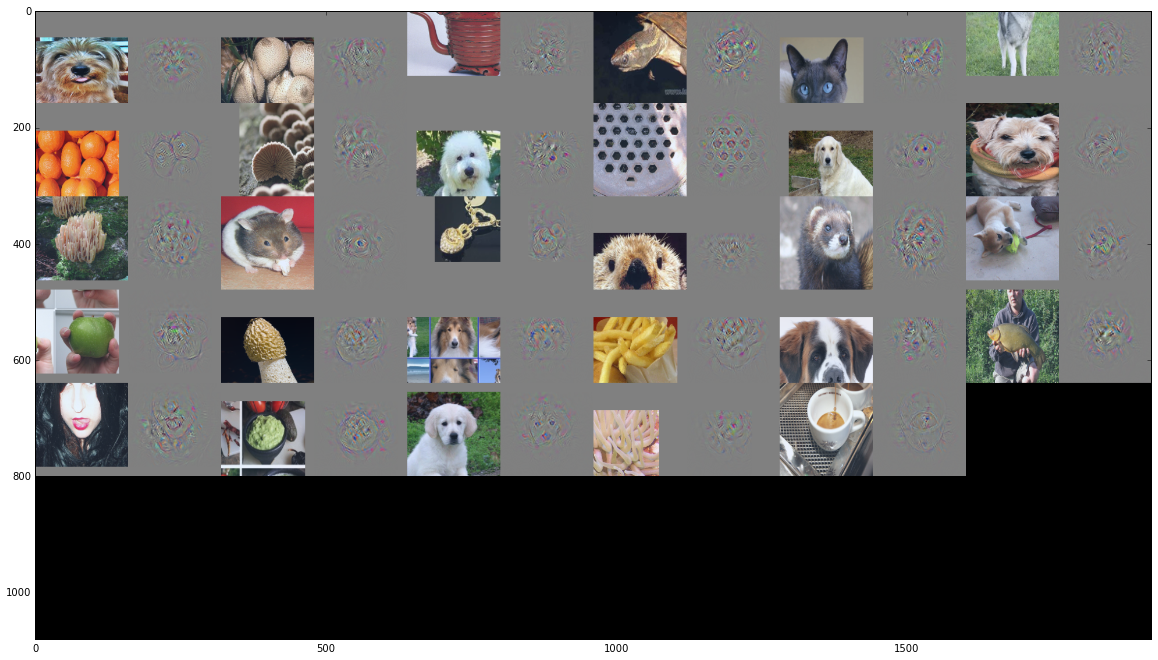

Group 1: 101
(1, 101, 20, 11, 110)


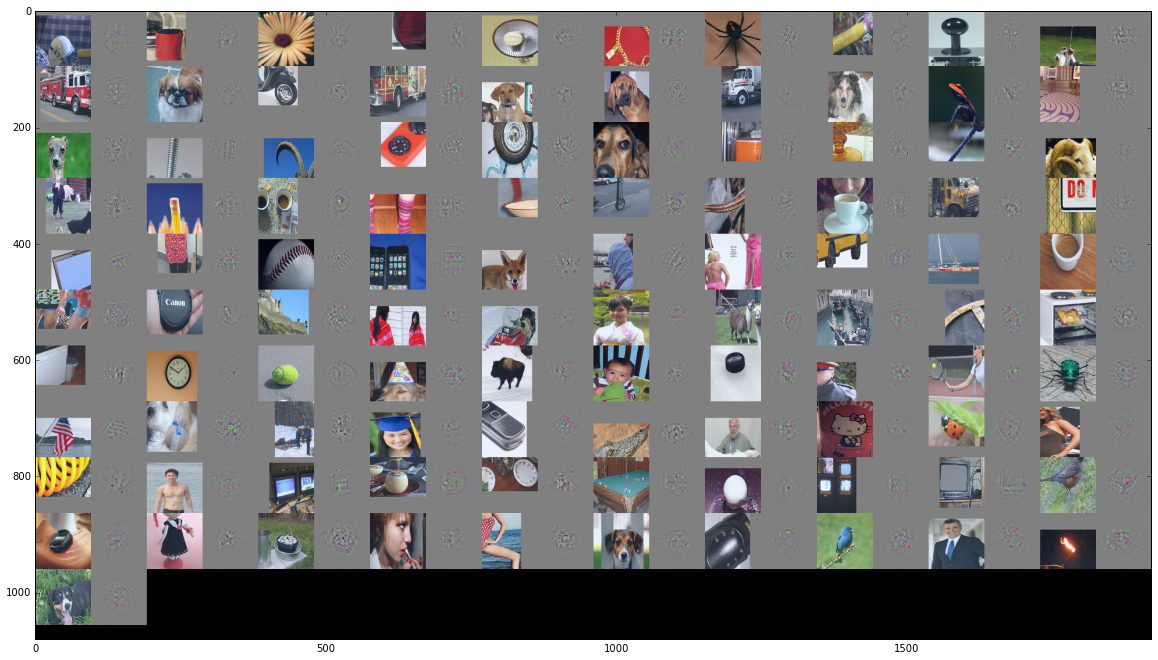

Group 2: 96
(1, 96, 20, 10, 100)


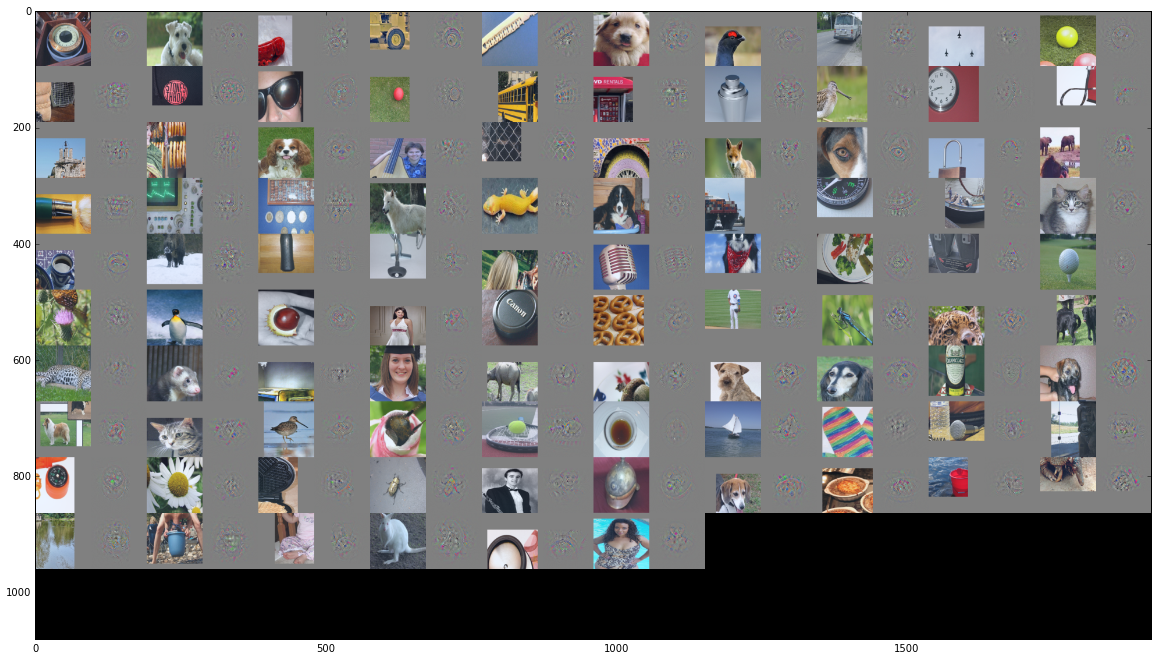

Group 3: 30
(1, 30, 12, 5, 30)


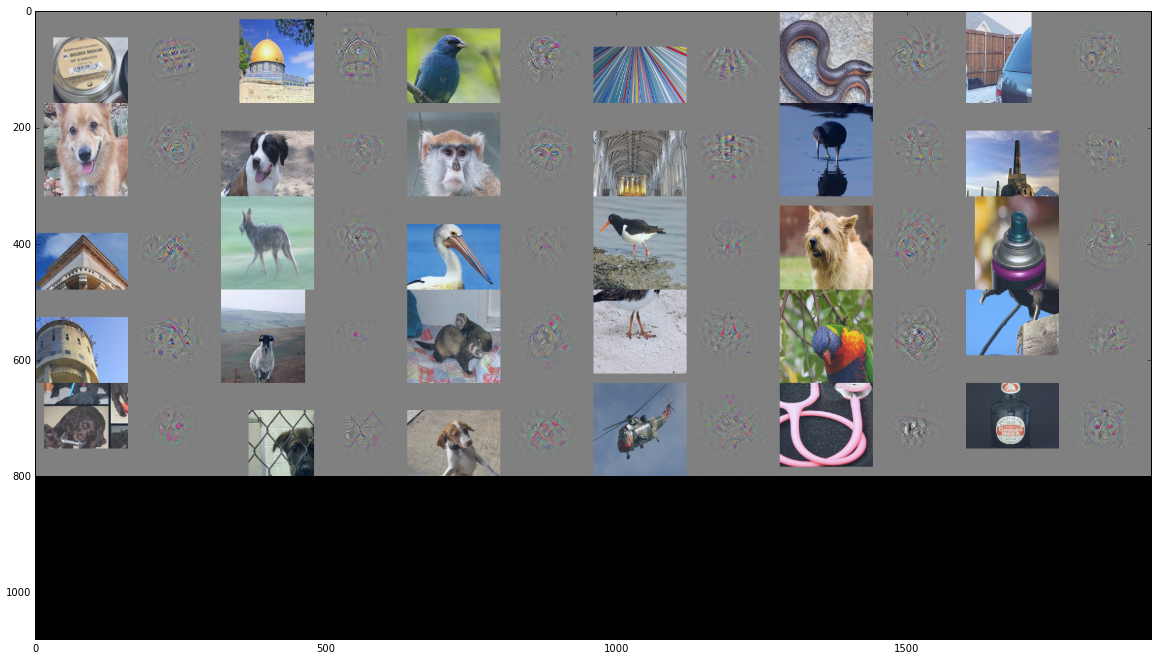

In [80]:
def visualize(group):
    nodes = []
    for i in range(mode.size):
        if mode[i] == group:
            nodes.append({'layer': 'conv5', 'index': i})
    print("Group " + str(group) + ": " + str(len(nodes)))
    if len(nodes) == 0:
        return
    fig = plt.figure(figsize=(20, 13))
    plt.imshow(visualizer.visualize_in_grid(nodes))
    plt.show()
    
for group in range(0, num_clusters):
    visualize(group)